## 划分训练集集和测试集的Gaussian Process Regression（GPR）实践
#### 赵四维 521021910696
#### 2022-2023-3 SUMMER WEEK3&WEEK4
##### PRP43_基于深度学习的机器人加工颤振在线辨识与智能抑振研究


      上一次我大致了解了GPR的相关原理，不能说算是完全掌握，因为当中的一些计算原理实在晦涩难懂。但我认为我们的重点应该放在如何处理已知的数据，也就是我们通过锤击法获得的数据集。数据的输入通常是一个高维的数组，通过GPR预测，可以行之有效的预测震颤(chatter)的发生，规避切削加工过程中的误差。
***

这次我从网上下载了一个数据集来练手，这个数据集是一个$3\times 2500$的数组，$row1,row2$是输入的自变量信息，我们可以假设理解为“锤击点在工件坐标系下的位置$(x,y)$”,$row3$代表因变量（特征）,可以理解为发生震颤的“*某项指标*”(涉及到相关震颤理论，仍在学习中)。我们的目标是通过$2300$组数据来进行预测，后$200$组作为测试集，并计算相关误差，比较不同kernel的优劣，以及迭代次数对准确率的影响等指标。

先来看看数据长啥样：

In [65]:
import pandas as pd
original_data=pd.read_excel("data.xlsx")
original_data

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,40.706703,40.706703,40.706703,40.706703,40.706703,40.706703,40.706703,40.706703,40.706703,40.706703,...,32.552113,32.552113,32.552113,32.552113,32.552113,32.552113,32.552113,32.552113,32.552113,32.552113
1,79.970233,52.669923,65.559185,10.677374,0.421907,62.227083,67.836360,25.533911,5.419446,83.059479,...,4.565033,45.069741,66.442637,21.423208,86.408500,34.073450,84.110615,65.718480,51.621266,14.520029
2,2070.656210,2846.765777,2068.332932,2069.592333,2066.915818,2067.404111,2068.925481,2070.288692,2068.293391,2070.545307,...,2028.401874,2021.514471,2029.629106,2034.256483,2033.258213,2029.473165,2033.881417,2029.170216,2772.748550,2033.456999


### 数据预处理阶段

对数据进行随机打乱（Shuffle）操作并转置：

In [66]:
from sklearn.utils import shuffle
new_data=shuffle(original_data.T)
new_data

,0,1,2
1893,85.277667,66.442637,-100.000000
1770,56.616970,14.747628,2188.628653
2280,14.958572,0.850544,1980.751567
483,60.968455,54.515480,3122.884143
245,53.663077,86.408500,2162.147637
...,...,...,...
2128,47.708080,43.976658,2115.739903
1470,25.671019,14.747628,2013.314834
129,1.051111,46.492708,2657.777590
826,28.235858,48.491373,2741.999557


接下来划分训练集和测试集，其中训练集和测试集又可以划分为输入和输出：

In [67]:
#训练集输入
train_data=new_data.iloc[:2300,:2]
train_data

,0,1
1893,85.277667,66.442637
1770,56.616970,14.747628
2280,14.958572,0.850544
483,60.968455,54.515480
245,53.663077,86.408500
...,...,...
1301,20.371453,79.970233
1043,44.492552,66.442637
937,47.155572,46.769349
241,53.663077,4.565033


In [68]:
#训练集输出
train_out_data=new_data.iloc[:2300,2:3]
train_out_data

,2
1893,-100.000000
1770,2188.628653
2280,1980.751567
483,3122.884143
245,2162.147637
...,...
1301,2004.420594
1043,2092.020911
937,2920.944832
241,2163.755763


In [69]:
#同理划分测试集输入、输出
test_data=new_data.iloc[2300:2500,:2]
test_out_data=new_data.iloc[2300:2500,2:3]
test_out_data

,2
1347,2003.696976
1750,2001.911782
699,3347.148248
2429,3304.741815
1068,2005.626271
...,...
2128,2115.739903
1470,2013.314834
129,2657.777590
826,2741.999557


In [70]:
input_arr=train_data.to_numpy()
output_arr=train_out_data.to_numpy()
test_input_arr=test_data.to_numpy()
test_output_arr=test_out_data.to_numpy()
output_arr

array([[-100.        ],
       [2188.6286529 ],
       [1980.7515671 ],
       ...,
       [2920.94483242],
       [2163.75576339],
       [3306.13177977]])

当然，别忘了将Dataframe格式转化为Numpy中方便处理的array数组格式。这样既便于作为参数传入GPR模型，在后续的作图过程中亦有帮助。

###  Sklearn-GPR for DotProduct(点积内核)

In [91]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,ConstantKernel
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.metrics import mean_absolute_error # 平方绝对误差
from sklearn.metrics import r2_score # R square

DWkernel = ConstantKernel(0.1, (1e-23, 1e5))*DotProduct()+WhiteKernel(0.1, (1e-23, np.inf))
gpr = GaussianProcessRegressor(kernel=DWkernel,random_state=0) # 创建一个高斯过程回归模型

X = input_arr 
y = output_arr  
gpr.fit(X, y) 

y_mean, y_std = gpr.predict(test_input_arr, return_std=True) 

MSE=mean_squared_error(test_out_data,y_mean)
MAE=mean_absolute_error(test_out_data,y_mean)
R2S=r2_score(test_out_data,y_mean)
RMSE=np.sqrt(MSE)
print("GPR(Kernel : DotProduct&WhiteKernel) 指标展示板")
print("均方误差(MSE):",MSE)
print("平方绝对误差(MAE):",MAE)
print("均方根误差(RMSE):",RMSE)
print("决定系数(R²):",R2S)

GPR(Kernel : DotProduct&WhiteKernel) 指标展示板
均方误差(MSE): 431178.27329241514
平方绝对误差(MAE): 382.21010163155296
均方根误差(RMSE): 656.6416627753795
决定系数(R²): 0.01417918378137073


Text(0.5, 1.0, 'Gaussian Process Regression  (Kernel : DotProduct&WhiteKernel)')

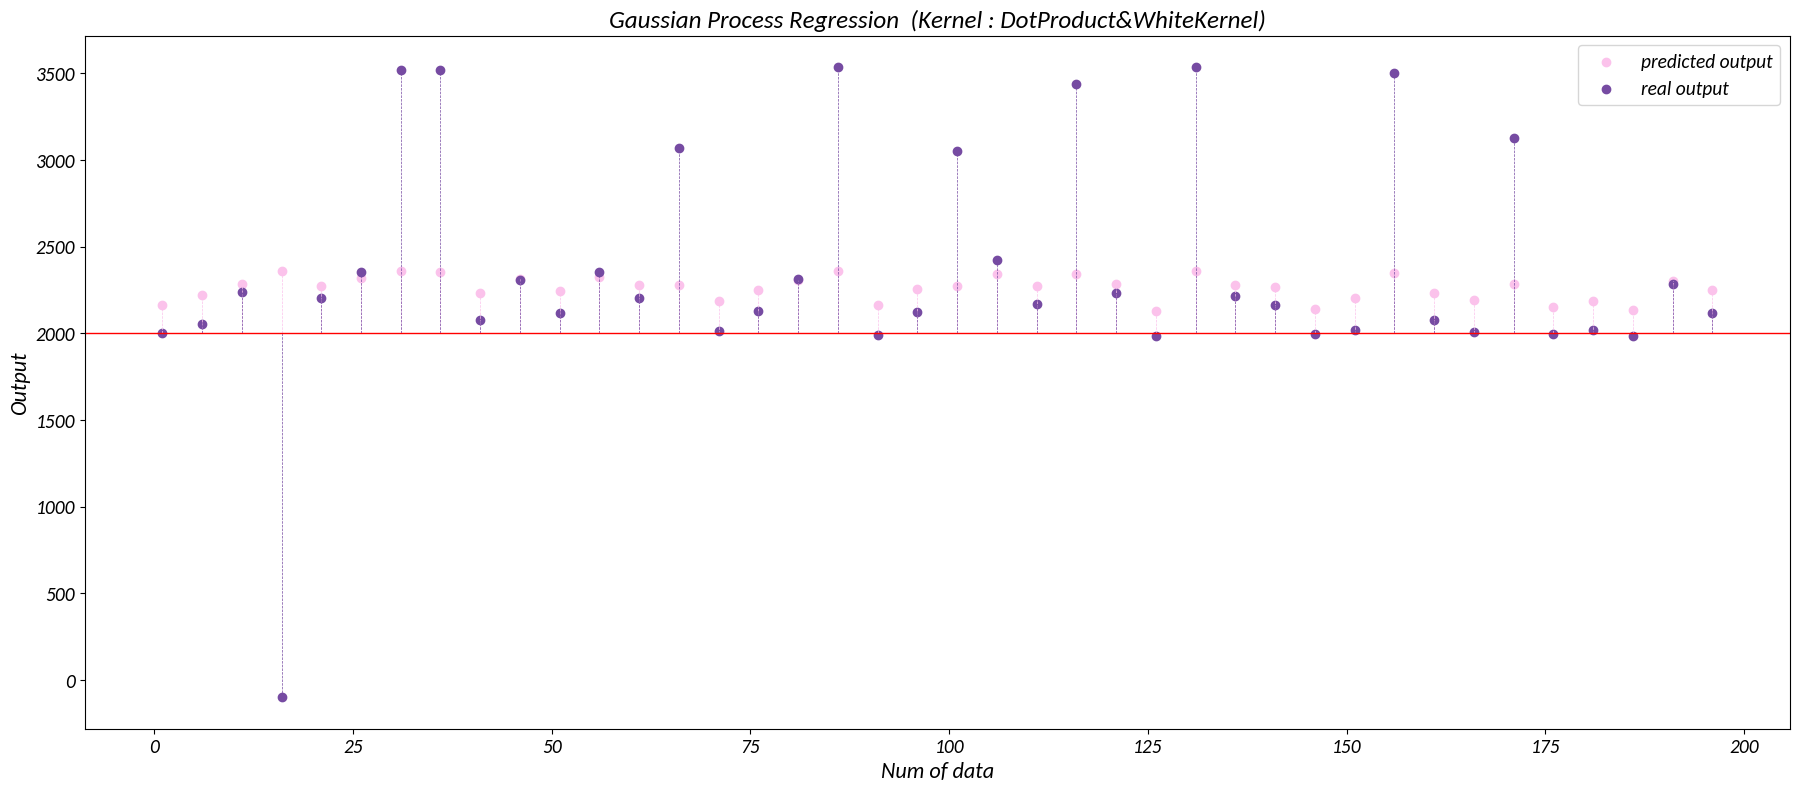

In [72]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']
font=FontProperties(fname=r".\Carlito-Italic.ttf",size=14)
fig = plt.figure(figsize=(22, 9))
x=list(range(1,201))
plt.scatter(x[::5], y_mean[::5],label="predicted output",color='#fbc2eb')
plt.scatter(x[::5],test_output_arr[::5],label="real output",color='#764ba2')
plt.vlines(x[::5], 2000, y_mean[0::5], colors='#fbc2eb', linestyles='dashed', linewidths=0.5)
plt.vlines(x[::5], 2000, test_output_arr[0::5], colors='#764ba2', linestyles='dashed', linewidths=0.5)
plt.axhline(2000,-2,202,color='red',linestyle='-',linewidth=1)

plt.xlabel("Num of data",fontproperties = font, size = 16)
plt.ylabel("Output",fontproperties = font, size = 16)
plt.legend(loc='best', fontsize=18)
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.legend(prop=font)
plt.title("Gaussian Process Regression  (Kernel : DotProduct&WhiteKernel)",fontproperties=font,size=18)

可以看到这个Kernel的拟合效果可以说是非常的差。DotProduct+WhiteKernel核函数的意义是假设数据的函数值和输入向量的内积成正比，加上一个白噪声项。这个核函数可能不能很好地捕捉数据的非线性特征，可能导致过拟合或欠拟合，因此这个方法不适用。

### Sklearn-GPR for Radial basis function Kernel(径向基核函数)

其实由上面的图我们可以看到在数据中存在一些实际输出为负数的值，而且都是-100作为output，可能是一些干扰的数据，正常情况下我们应该采集不到这样的数据，并且，但是接下来我们使用的Radial basis function Kernel(RBF)，通过设置RBF核的步长，我得到了更好的拟合效果————已经可以初步看到，不仅能预测出异常值，$R^2$ Score也有了明显的提高。

In [89]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel
RBFkernel = ConstantKernel(3) * RBF(0.15, (1e-23, np.inf)) + WhiteKernel(0.1, (1e-23, np.inf))

gpr = GaussianProcessRegressor(kernel=RBFkernel)

gpr.fit(X, y) 

y_mean, y_std = gpr.predict(test_input_arr, return_std=True) 

MSE=mean_squared_error(test_out_data,y_mean)
MAE=mean_absolute_error(test_out_data,y_mean)
R2S=r2_score(test_out_data,y_mean)
RMSE=np.sqrt(MSE)
print("GPR(Kernel : RBF) 指标展示板")
print("均方误差(MSE):",MSE)
print("平方绝对误差(MAE):",MAE)
print("均方根误差(RMSE):",RMSE)
print("决定系数(R²):",R2S)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR(Kernel : RBF) 指标展示板
均方误差(MSE): 262143.74695665482
平方绝对误差(MAE): 234.39978535633657
均方根误差(RMSE): 511.9997528872986
决定系数(R²): 0.40064985042472157


Text(0.5, 1.0, 'Gaussian Process Regression  (Kernel : RBF&WhiteKernel)')

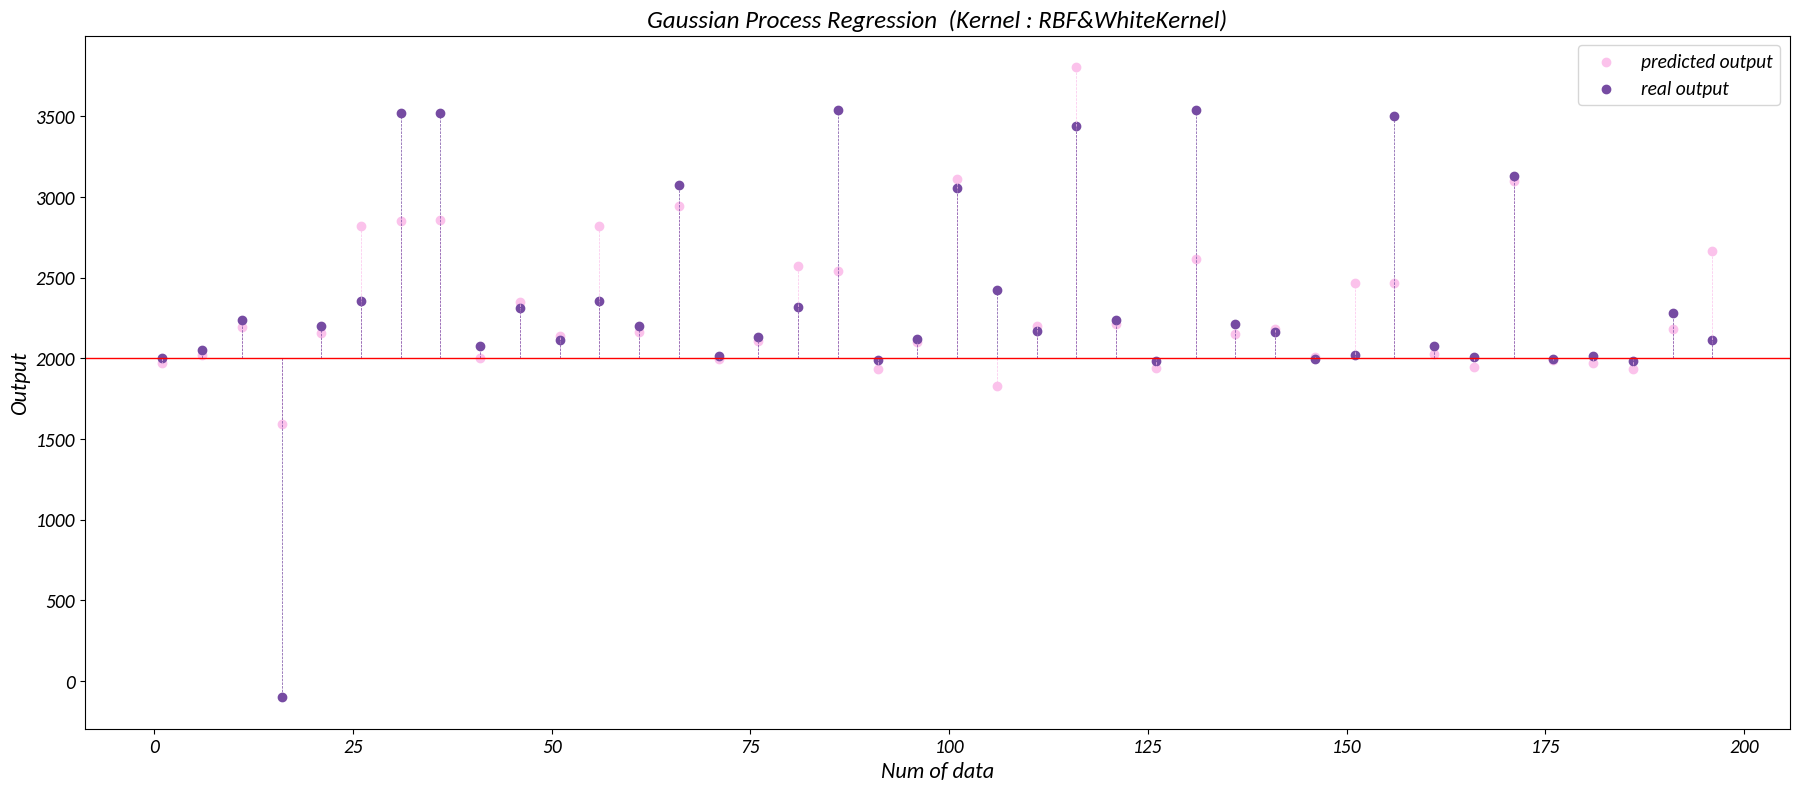

In [74]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']
font=FontProperties(fname=r".\Carlito-Italic.ttf",size=14)
fig = plt.figure(figsize=(22, 9))
x=list(range(1,201))
plt.scatter(x[::5], y_mean[::5],label="predicted output",color='#fbc2eb')
plt.scatter(x[::5],test_output_arr[::5],label="real output",color='#764ba2')
plt.vlines(x[::5], 2000, y_mean[0::5], colors='#fbc2eb', linestyles='dashed', linewidths=0.5)
plt.vlines(x[::5], 2000, test_output_arr[0::5], colors='#764ba2', linestyles='dashed', linewidths=0.5)
plt.axhline(2000,-2,202,color='red',linestyle='-',linewidth=1)

plt.xlabel("Num of data",fontproperties = font, size = 16)
plt.ylabel("Output",fontproperties = font, size = 16)
plt.legend(loc='best', fontsize=18)
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.legend(prop=font)
plt.title("Gaussian Process Regression  (Kernel : RBF&WhiteKernel)",fontproperties=font,size=18)

### Sklearn-GPR for Matérn kernel(Matérn核函数)

In [92]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
Matrenkernel=ConstantKernel(3)*Matern(0.15, (1e-23, np.inf),nu=np.inf)+WhiteKernel(0.1, (1e-23, np.inf))
gpr = GaussianProcessRegressor(kernel=Matrenkernel)

gpr.fit(X, y) 

y_mean, y_std = gpr.predict(test_input_arr, return_std=True) 

MSE=mean_squared_error(test_out_data,y_mean)
MAE=mean_absolute_error(test_out_data,y_mean)
R2S=r2_score(test_out_data,y_mean)
RMSE=np.sqrt(MSE)
print("GPR(Kernel : Matérn kernel) 指标展示板")
print("均方误差(MSE):",MSE)
print("平方绝对误差(MAE):",MAE)
print("均方根误差(RMSE):",RMSE)
print("决定系数(R²):",R2S)


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR(Kernel : Matérn kernel) 指标展示板
均方误差(MSE): 262143.74695665456
平方绝对误差(MAE): 234.3997853563365
均方根误差(RMSE): 511.9997528872983
决定系数(R²): 0.40064985042472223


Text(0.5, 1.0, 'Gaussian Process Regression  (Kernel : Matérn Kernel)')

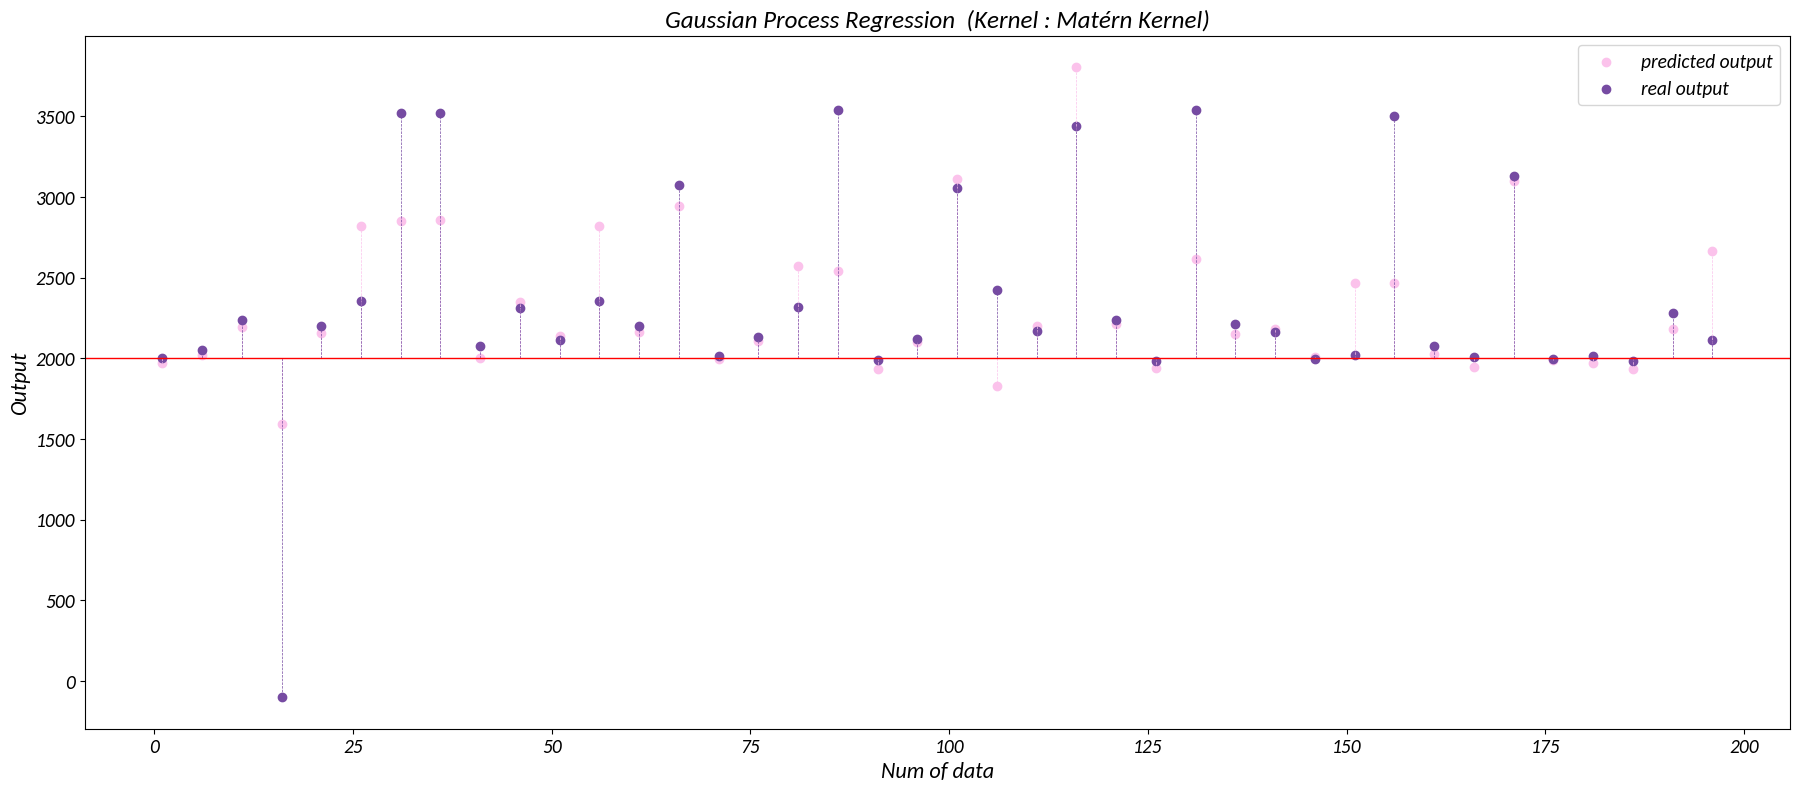

In [80]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']
font=FontProperties(fname=r".\Carlito-Italic.ttf",size=14)
fig = plt.figure(figsize=(22, 9))
x=list(range(1,201))
plt.scatter(x[::5], y_mean[::5],label="predicted output",color='#fbc2eb')
plt.scatter(x[::5],test_output_arr[::5],label="real output",color='#764ba2')
plt.vlines(x[::5], 2000, y_mean[0::5], colors='#fbc2eb', linestyles='dashed', linewidths=0.5)
plt.vlines(x[::5], 2000, test_output_arr[0::5], colors='#764ba2', linestyles='dashed', linewidths=0.5)
plt.axhline(2000,-2,202,color='red',linestyle='-',linewidth=1)

plt.xlabel("Num of data",fontproperties = font, size = 16)
plt.ylabel("Output",fontproperties = font, size = 16)
plt.legend(loc='best', fontsize=18)
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.legend(prop=font)
plt.title("Gaussian Process Regression  (Kernel : Matérn Kernel)",fontproperties=font,size=18)

这个Matérn kernel吧，还行……但是好像还是不太准确

### Sklearn-GPR for Rational quadratic kernel（有理二次核函数）

#### 采用默认优化方式（RQ Kernel）

In [77]:
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel
RQkernel=ConstantKernel(0.1, (1e-23, 1e5))*RationalQuadratic(1.0, 1.5)+WhiteKernel(0.1, (1e-23, 1e5))
gpr = GaussianProcessRegressor(kernel=RQkernel)

gpr.fit(X, y) 

y_mean, y_std = gpr.predict(test_input_arr, return_std=True) 

MSE=mean_squared_error(test_out_data,y_mean)
MAE=mean_absolute_error(test_out_data,y_mean)
R2S=r2_score(test_out_data,y_mean)
RMSE=np.sqrt(MSE)
print("GPR(Kernel : Rational quadratic kernel) 指标展示板")
print("均方误差(MSE):",MSE)
print("平方绝对误差(MAE):",MAE)
print("均方根误差(RMSE):",RMSE)
print("决定系数(R²):",R2S)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR(Kernel : DotProduct&WhiteKernel) 指标展示板
均方误差(MSE): 149005.28086106016
平方绝对误差(MAE): 125.55210781539695
均方根误差(RMSE): 386.01202165354925
决定系数(R²): 0.6593230301756942


Text(0.5, 1.0, 'Gaussian Process Regression  (Kernel : Rational quadratic kernel)')

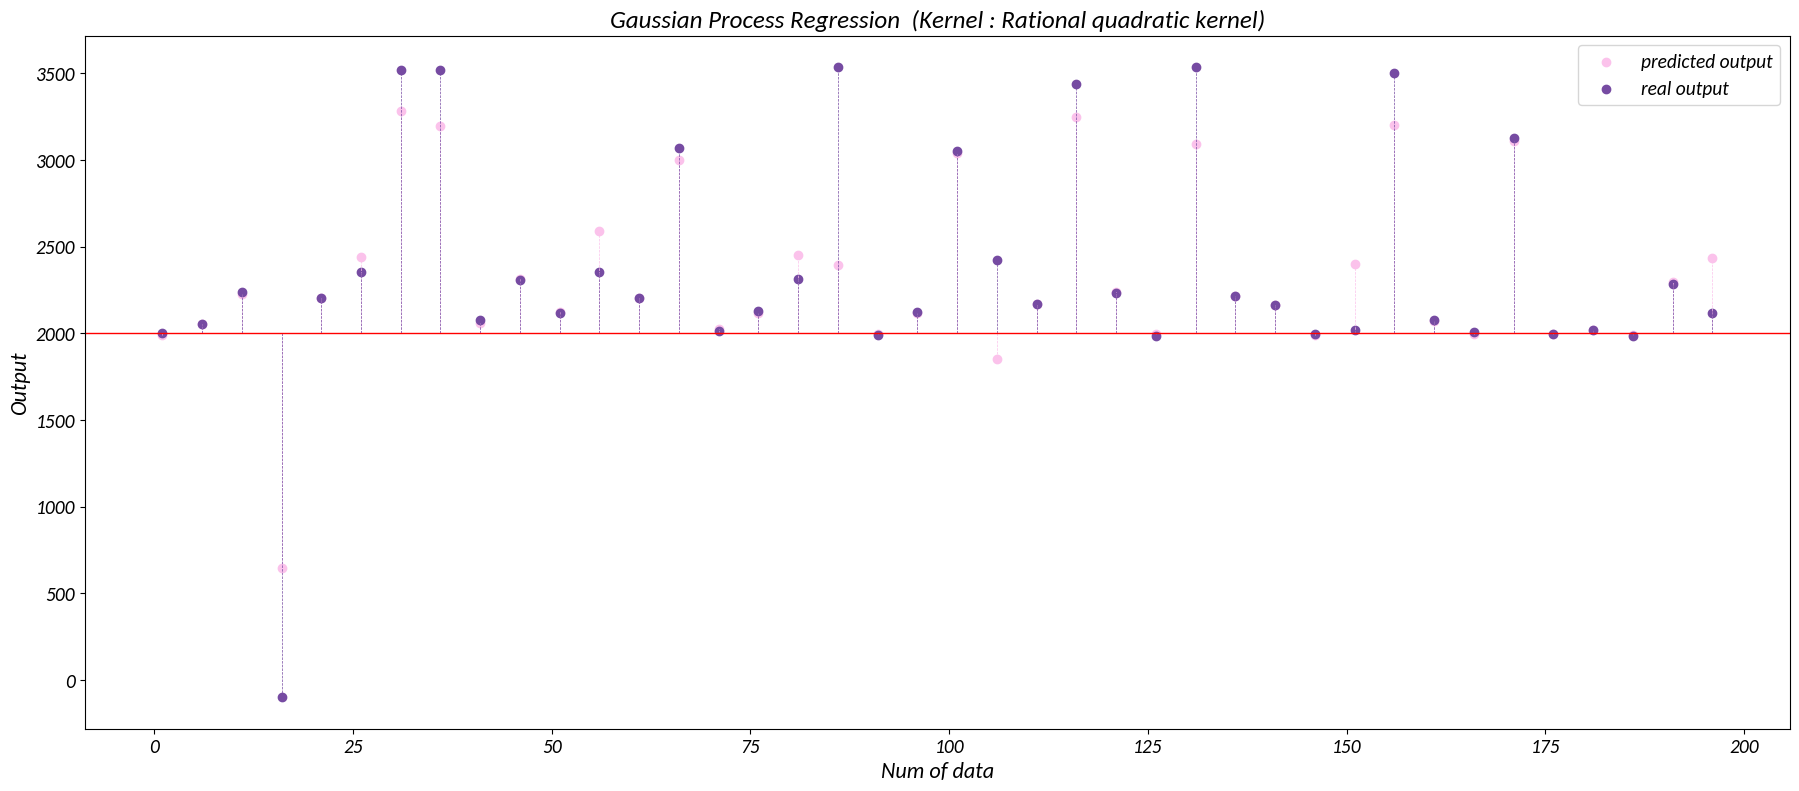

In [78]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']
font=FontProperties(fname=r".\Carlito-Italic.ttf",size=14)
fig = plt.figure(figsize=(22, 9))
x=list(range(1,201))
plt.scatter(x[::5], y_mean[::5],label="predicted output",color='#fbc2eb')
plt.scatter(x[::5],test_output_arr[::5],label="real output",color='#764ba2')
plt.vlines(x[::5], 2000, y_mean[0::5], colors='#fbc2eb', linestyles='dashed', linewidths=0.5)
plt.vlines(x[::5], 2000, test_output_arr[0::5], colors='#764ba2', linestyles='dashed', linewidths=0.5)
plt.axhline(2000,-2,202,color='red',linestyle='-',linewidth=1)

plt.xlabel("Num of data",fontproperties = font, size = 16)
plt.ylabel("Output",fontproperties = font, size = 16)
plt.legend(loc='best', fontsize=18)
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.legend(prop=font)
plt.title("Gaussian Process Regression  (Kernel : Rational quadratic kernel)",fontproperties=font,size=18)

这里已经明显看到我们的模型有了很大的提高！接下来便是加入迭代次数进行分析，从这里开始，一个cell内的程序运行时间明显变长。

#### 引入迭代次数的回归分析（RQ Kernel）

In [83]:
# 导入相关库
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel

# 定义均值函数为常数3
meanfunc = ConstantKernel(constant_value=3)
covfunc = RationalQuadratic(length_scale=1.0, alpha=1.0)
likfunc = 0.1 # 噪声方差

# 创建高斯过程回归模型，使用负梯度下降法优化超参数
gp = GaussianProcessRegressor(kernel=meanfunc * covfunc, alpha=likfunc, n_restarts_optimizer=20)

# 训练模型
gp.fit(input_arr,output_arr)
y_mean,y_std = gp.predict(test_input_arr, return_std=True)
MSE=mean_squared_error(test_out_data,y_mean)
MAE=mean_absolute_error(test_out_data,y_mean)
R2S=r2_score(test_out_data,y_mean)
RMSE=np.sqrt(MSE)
print("GPR(Kernel : Rational quadratic kernel) 指标展示板")
print("均方误差(MSE):",MSE)
print("平方绝对误差(MAE):",MAE)
print("均方根误差(RMSE):",RMSE)
print("决定系数(R²):",R2S)


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR(Kernel : Rational quadratic kernel) 指标展示板
均方误差(MSE): 102354.63220665816
平方绝对误差(MAE): 83.56026165144029
均方根误差(RMSE): 319.9291049696138
决定系数(R²): 0.7659823481010718


已经超过0.75了！还是算很成功！但是运行了8分多钟……

Text(0.5, 1.0, 'Gaussian Process Regression  (Kernel : Rational quadratic kernel with iteration)')

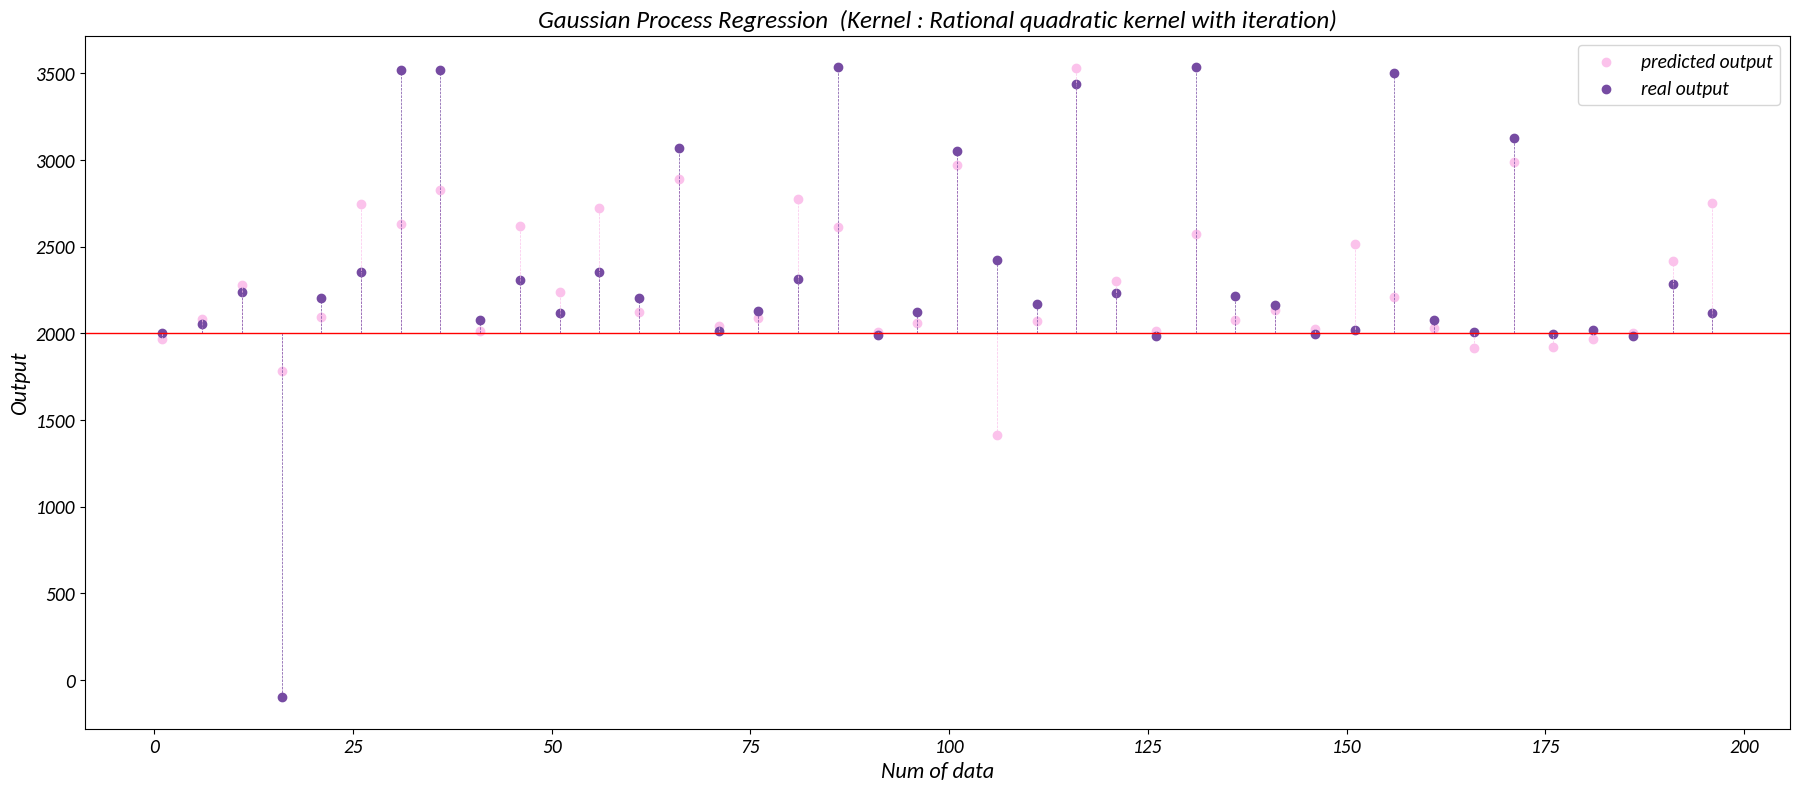

In [93]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']
font=FontProperties(fname=r".\Carlito-Italic.ttf",size=14)
fig = plt.figure(figsize=(22, 9))
x=list(range(1,201))
plt.scatter(x[::5], y_mean[::5],label="predicted output",color='#fbc2eb')
plt.scatter(x[::5],test_output_arr[::5],label="real output",color='#764ba2')
plt.vlines(x[::5], 2000, y_mean[0::5], colors='#fbc2eb', linestyles='dashed', linewidths=0.5)
plt.vlines(x[::5], 2000, test_output_arr[0::5], colors='#764ba2', linestyles='dashed', linewidths=0.5)
plt.axhline(2000,-2,202,color='red',linestyle='-',linewidth=1)

plt.xlabel("Num of data",fontproperties = font, size = 16)
plt.ylabel("Output",fontproperties = font, size = 16)
plt.legend(loc='best', fontsize=18)
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.legend(prop=font)
plt.title("Gaussian Process Regression  (Kernel : Rational quadratic kernel with iteration)",fontproperties=font,size=18)

## 基于MATLAB的GPR实践

当然，我们不要忘了还有一项工程数学的神器MATLAB。MATLAB中有机器学习的现成库，封装完好。使用之后惊喜的发现MATLAB的计算速度超乎预料，并且得到的$R^2$ Score也出乎意料的完美。搜集相关资料后了解到Python的SKlearn库中的GPR类可能没有充分利用GPU的并行计算能力，而是使用了CPU来进行计算，在运算过程中可能较慢，且容易导致硬件发热。

In [ ]:
addpath(genpath(pwd))  


load('train.mat');
%% 乱序生成训练集和测试集
b = train_data;
rowrank = randperm(size(b,2));    % size获得b的列数，randperm打乱各列的顺序
randIndex= b(:,rowrank);          % 按照rowrank重新排列各列，注意rowrank的位置
train =randIndex(:,1:2300);
test = randIndex(:,2301:2500);
%% 获得输入输出
p_train = train(1:2,:);            %训练样本输入
t_train = train(3,:);              %训练样本输出
p_test = test(1:2,:);              %测试样本输入
t_test = test(3,:);                %测试样本输出
%%转置
pn_train = p_train';
tn_train = t_train';
pn_test = p_test';
tn_test = t_test';
%% 超参数优化
meanfunc = @meanConst;              %设定均值函数
covfunc = @covRQiso;                %协方差函数（RQ）
likfunc = @likGauss;                %以及似然函数
hyp = struct('mean', 3, 'cov', [1 0 0], 'lik', -1);     %均值/cov/lik超参数列向量的hyp结构
hyp2 = minimize(hyp, @gp, -20, @infGaussLik, meanfunc, covfunc, likfunc,pn_train, tn_train);
%% 预测
% yfit是预测平均值，ys是预测方差
[yfit ys] = gp(hyp2, @infGaussLik, meanfunc, covfunc, likfunc,pn_train, tn_train, pn_test);
%% 画图
plot(1:length(tn_test),tn_test,'r-*',1:length(tn_test),yfit,'b:o')
grid on
legend('真实值','预测值')
xlabel('样本编号')
ylabel('GDOP')
title('高斯过程回归预测值与真实值对比')
%plotResult(tn_test, yfit) %结果可视化
%title('高斯过程回归误差')
%% 计算误差
error=yfit-tn_test;
[len,~]=size(tn_test);
MAE1=sum(abs(error./tn_test))/len;
MSE1=error'*error/len;
RMSE1=MSE1^(1/2);
R = corrcoef(tn_test,yfit);
r = R(1,2);
% [R2 rmse] = rsquare(tn_test,yfit);
disp(['.....高斯过程回归误差计算................'])
disp(['平均绝对误差MAE为:',num2str(MAE1)])
disp(['均方误差为MSE:',num2str(MSE1)])
disp(['均方根误差RMSE为:',num2str(RMSE1)])
disp(['决定系数 R^2为:',num2str(r)])

某一次的运行结果如下（因为打乱顺序可能不同），这一过程在MATLAB中*只运行了30s不到*的时间，速度可谓相当惊人：

平均绝对误差MAE为: $0.26449$

均方误差为MSE: $65829.8356$

均方根误差RMSE为: $256.5733$

决定系数$R^2$ 为: $0.93455$

MATLAB拟合的非常好，情况如下图：

![avatar](./MATLAB运行结果.png)

#### 迭代次数对$R^2$ Score的影响
由于MATLAB在GPU上运行，速度很快。因此把循环写在MATLAB里，用Jupyter的kernel来画图。

一共做了30组实验，分别迭代2，4，6，……，30次。

Text(0.5, 1.0, '$R^2$ Score for different iteration times')

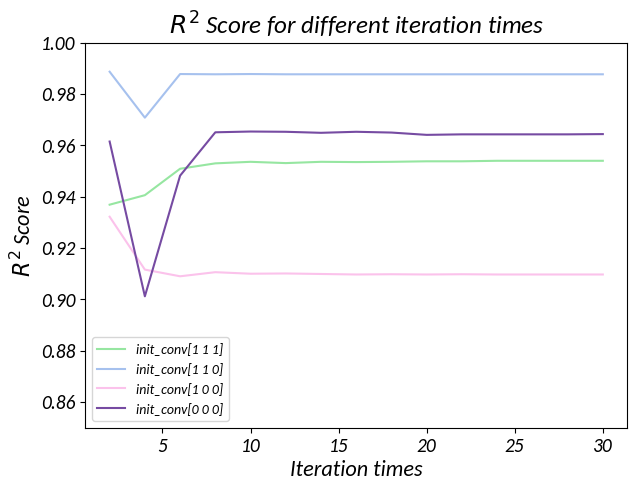

In [117]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
R2SCORE_100=[0.9322,0.9116,0.9090,0.9106,0.9100,0.9101,0.9099,0.9097,0.9098,0.9097,0.9098,0.9097,0.9097,0.9097,0.9097]
R2SCORE_000=[0.9615,0.9012,0.9482,0.9651,0.9654,0.9653,0.9649,0.9653,0.9650,0.9641,0.9643,0.9643,0.9643,0.9643,0.9644]
R2SCORE_110=[0.9887,0.9708,0.9878,0.9877,0.9878,0.9877,0.9877,0.9877,0.9877,0.9877,0.9877,0.9877,0.9877,0.9877,0.9877]
R2SCORE_111=[0.9369,0.9406,0.9509,0.9530,0.9536,0.9531,0.9536,0.9535,0.9536,0.9538,0.9538,0.9540,0.9540,0.9540,0.9540]
iter_times=[]
for i in range(15):
    iter_times.append(2+i*2)

plt.rcParams['font.sans-serif'] = ['SimHei']
font=FontProperties(fname=r".\Carlito-Italic.ttf",size=10)

fig = plt.figure(figsize=(7,5))
plt.plot(iter_times,R2SCORE_111,color='#96e6a1',label='init_conv[1 1 1]')
plt.plot(iter_times,R2SCORE_110,color='#a6c1ee',label='init_conv[1 1 0]')
plt.plot(iter_times,R2SCORE_100,color='#fbc2eb',label='init_conv[1 0 0]')
plt.plot(iter_times,R2SCORE_000,color='#764ba2',label='init_conv[0 0 0]')
plt.ylim(0.85,1)

plt.xlabel("Iteration times",fontproperties = font, size = 16)
plt.ylabel("$R^2$ Score",fontproperties = font, size = 16)

plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.legend(prop=font)
plt.title("$R^2$ Score for different iteration times",fontproperties=font,size=18)

这是初始协方差矩阵对$R^2$ Score的影响，有意思的是居然在iter=4左右图像会有转折，具体的原因我还没想清楚。后续我将接着分析一些其他超参数对拟合程度的影响，以上便是我最近的工作。